In [46]:
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score

from scipy.sparse import csr_matrix

plt.style.use('default')
sns.set_style("whitegrid")


# Clustering-Based News Recommendation System

## 1. Dataset Loading


In [47]:
# Load dataset
notebook_dir = Path(os.getcwd())
data_root = notebook_dir / 'MINDsmall_train'

news = pd.read_csv(
    data_root / 'news.tsv',
    sep='\t',
    header=None,
    names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'],
    on_bad_lines='skip'
)

behaviors = pd.read_csv(
    data_root / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

print(f"Dataset: {len(news):,} articles, {len(behaviors):,} impressions, {behaviors['user_id'].nunique():,} users")


Dataset: 51,282 articles, 156,965 impressions, 50,000 users


In [48]:
# Dataset statistics
print(f"Articles: {len(news):,}, Categories: {news['category'].nunique()}")
print(f"Impressions: {len(behaviors):,}, Users: {behaviors['user_id'].nunique():,}")
print(f"Missing abstracts: {news['abstract'].isna().sum()}")


Articles: 51,282, Categories: 17
Impressions: 156,965, Users: 50,000
Missing abstracts: 2666


## 2. Data Preprocessing


In [49]:
def parse_impressions(impression_str):
    """Parse impression string format: 'N123-1 N456-0' -> (items, labels)"""
    if pd.isna(impression_str) or impression_str == '':
        return [], []
    items, labels = [], []
    for pair in str(impression_str).split():
        try:
            nid, lbl = pair.split('-')
            items.append(nid)
            labels.append(int(lbl))
        except ValueError:
            continue
    return items, labels

# Parse impressions
behaviors['imp_items'], behaviors['imp_labels'] = zip(
    *behaviors['impressions'].apply(parse_impressions)
)

# Calculate click statistics
total_impressions = behaviors['imp_items'].apply(len).sum()
total_clicks = behaviors['imp_labels'].apply(sum).sum()
click_rate = total_clicks / total_impressions if total_impressions > 0 else 0

print(f"Impressions: {total_impressions:,}, Clicks: {total_clicks:,}, Click rate: {click_rate:.2%}")


Impressions: 5,843,444, Clicks: 236,344, Click rate: 4.04%


## 3. Build User Click Histories


In [50]:
# Build user click history
user_clicked = {}
for _, row in behaviors.iterrows():
    uid = row['user_id']
    clicked = [item for item, label in zip(row['imp_items'], row['imp_labels']) if label == 1]
    if uid not in user_clicked:
        user_clicked[uid] = []
    user_clicked[uid].extend(clicked)

# Remove duplicates
for uid in user_clicked:
    user_clicked[uid] = list(dict.fromkeys(user_clicked[uid]))

click_counts = [len(clicks) for clicks in user_clicked.values()]
print(f"Users: {len(user_clicked):,}, Average clicks per user: {np.mean(click_counts):.2f}, Median: {np.median(click_counts):.1f}")

# Build article popularity for cold-start fallback
article_popularity = {}
for _, row in behaviors.iterrows():
    for item, label in zip(row['imp_items'], row['imp_labels']):
        if label == 1:
            article_popularity[item] = article_popularity.get(item, 0) + 1

if article_popularity:
    max_pop = max(article_popularity.values())
    article_popularity = {k: v / max_pop for k, v in article_popularity.items()}
print(f"Articles with popularity scores: {len(article_popularity):,}")


Users: 50,000, Average clicks per user: 4.69, Median: 3.0
Articles with popularity scores: 7,713


## 4. Build User-Item Matrix


In [51]:
# Create user-item interaction matrix
# Rows: users, Columns: articles, Values: 1 if clicked, 0 otherwise
all_users = sorted(list(user_clicked.keys()))
all_articles = sorted(list(set().union(*[set(clicks) for clicks in user_clicked.values()])))

user_to_idx = {uid: i for i, uid in enumerate(all_users)}
article_to_idx = {aid: i for i, aid in enumerate(all_articles)}

# Build sparse matrix
row_indices = []
col_indices = []
data = []

for uid, clicked_articles in user_clicked.items():
    user_idx = user_to_idx[uid]
    for article_id in clicked_articles:
        if article_id in article_to_idx:
            col_idx = article_to_idx[article_id]
            row_indices.append(user_idx)
            col_indices.append(col_idx)
            data.append(1.0)

user_item_matrix = csr_matrix((data, (row_indices, col_indices)), 
                              shape=(len(all_users), len(all_articles)))

print(f"User-Item matrix shape: {user_item_matrix.shape}")
print(f"Matrix density: {user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.6f}")
print(f"Users: {len(all_users):,}, Articles: {len(all_articles):,}")


User-Item matrix shape: (50000, 7713)
Matrix density: 0.000608
Users: 50,000, Articles: 7,713


## 5. K-Means Clustering


In [52]:
# Apply K-Means clustering to users based on their click patterns
# Convert sparse matrix to dense array for clustering (using a sample if too large)
n_clusters = 50  # Number of clusters
print(f"Applying K-Means clustering with {n_clusters} clusters...")

# Convert sparse matrix to dense (this might be memory intensive for large datasets)
# For efficiency, we can use a sample or work with sparse representation
# Here we'll convert to dense array
user_item_dense = user_item_matrix.toarray()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
user_clusters = kmeans.fit_predict(user_item_dense)

# Create mapping from user_id to cluster
user_to_cluster = {uid: user_clusters[i] for i, uid in enumerate(all_users)}

# Build cluster profiles: articles liked by users in each cluster
cluster_articles = {}  # cluster_id -> {article_id: count}
cluster_user_counts = {}  # cluster_id -> number of users

for i, uid in enumerate(all_users):
    cluster_id = user_clusters[i]
    if cluster_id not in cluster_articles:
        cluster_articles[cluster_id] = {}
        cluster_user_counts[cluster_id] = 0
    
    cluster_user_counts[cluster_id] += 1
    for article_id in user_clicked[uid]:
        if article_id in article_to_idx:
            cluster_articles[cluster_id][article_id] = cluster_articles[cluster_id].get(article_id, 0) + 1

# Normalize cluster article scores by cluster size
for cluster_id in cluster_articles:
    cluster_size = cluster_user_counts[cluster_id]
    if cluster_size > 0:
        cluster_articles[cluster_id] = {k: v / cluster_size for k, v in cluster_articles[cluster_id].items()}

print(f"Clustered {len(all_users):,} users into {n_clusters} clusters")
print(f"Cluster sizes: min={min(cluster_user_counts.values())}, max={max(cluster_user_counts.values())}, avg={np.mean(list(cluster_user_counts.values())):.1f}")


Applying K-Means clustering with 50 clusters...
Clustered 50,000 users into 50 clusters
Cluster sizes: min=1, max=24411, avg=1000.0


## 6. Scoring and Ranking


In [53]:
def score_impression(impression_row):
    """Score articles using cluster-based recommendations."""
    uid = impression_row['user_id']
    items = impression_row['imp_items']
    scores = np.zeros(len(items))
    
    # Get user's cluster
    if uid not in user_to_cluster:
        # Cold-start: use popularity
        for i, news_id in enumerate(items):
            scores[i] = article_popularity.get(news_id, 0.0) * 0.5
        return scores
    
    cluster_id = user_to_cluster[uid]
    cluster_profile = cluster_articles.get(cluster_id, {})
    
    # Score articles based on cluster profile
    for i, news_id in enumerate(items):
        # Get score from cluster profile
        cluster_score = cluster_profile.get(news_id, 0.0)
        scores[i] = cluster_score
    
    # Add popularity fallback for articles with no cluster support
    for i, news_id in enumerate(items):
        pop_score = article_popularity.get(news_id, 0.0)
        if scores[i] == 0:
            scores[i] = pop_score * 0.3
        else:
            scores[i] = scores[i] * 0.9 + pop_score * 0.1
    
    return scores


## 7. Evaluation


In [54]:
def evaluate_recommendations(behaviors_df, sample_size=None, random_seed=42):
    """Evaluate recommendation system using multiple metrics."""
    eval_df = behaviors_df.sample(n=min(sample_size, len(behaviors_df)), random_state=random_seed) if sample_size else behaviors_df.copy()
    
    hits_at_1 = 0
    reciprocal_ranks = []
    ndcg_scores = []
    auc_scores = []
    precision_scores = []
    f1_scores = []
    recall_scores = []
    total_evaluated = 0
    
    for _, row in eval_df.iterrows():
        scores = score_impression(row)
        labels = np.array(row['imp_labels'])
        
        if sum(labels) == 0 or np.all(scores == 0):
            continue
        
        total_evaluated += 1
        
        try:
            auc_scores.append(roc_auc_score(labels, scores))
        except ValueError:
            pass
        
        ranked_indices = np.argsort(scores)[::-1]
        
        if labels[ranked_indices[0]] == 1:
            hits_at_1 += 1
        
        clicked_ranks = [i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1]
        if clicked_ranks:
            reciprocal_ranks.append(1.0 / clicked_ranks[0])
        
        top_5_indices = ranked_indices[:5]
        dcg = sum((labels[idx] / np.log2(i + 2)) for i, idx in enumerate(top_5_indices))
        ideal_ranks = sorted([i + 1 for i, idx in enumerate(ranked_indices) if labels[idx] == 1])[:5]
        idcg = sum(1.0 / np.log2(rank + 1) for rank in ideal_ranks)
        ndcg_scores.append(dcg / idcg if idcg > 0 else 0.0)
        
        # Compute precision, recall, and F1 at top-5
        top_5_labels = labels[top_5_indices]
        top_5_predictions = np.ones_like(top_5_labels)  # All top-5 are predicted as positive
        precision_scores.append(precision_score(top_5_labels, top_5_predictions, zero_division=0))
        recall_scores.append(recall_score(top_5_labels, top_5_predictions, zero_division=0))
        f1_scores.append(f1_score(top_5_labels, top_5_predictions, zero_division=0))
    
    return {
        'Hit Rate @ 1': hits_at_1 / total_evaluated if total_evaluated > 0 else 0.0,
        'MRR': np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0,
        'NDCG @ 5': np.mean(ndcg_scores) if ndcg_scores else 0.0,
        'AUC': np.mean(auc_scores) if auc_scores else 0.0,
        'Precision @ 5': np.mean(precision_scores) if precision_scores else 0.0,
        'Recall @ 5': np.mean(recall_scores) if recall_scores else 0.0,
        'F1 @ 5': np.mean(f1_scores) if f1_scores else 0.0,
        'Coverage': total_evaluated / len(eval_df) if len(eval_df) > 0 else 0.0,
        'Total Evaluated': total_evaluated
    }

# Evaluate on training set
train_metrics = evaluate_recommendations(behaviors, sample_size=None, random_seed=42)
print("Training Set Results:")
for metric, value in train_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")


Training Set Results:
  Hit Rate @ 1: 0.2721
  MRR: 0.3973
  NDCG @ 5: 0.4826
  AUC: 0.6370
  Precision @ 5: 0.1408
  Recall @ 5: 0.5233
  F1 @ 5: 0.2159
  Coverage: 100.00%
  Total Evaluated: 156,965


In [55]:
def recommend_for_user(user_id, top_k=5, exclude_clicked=True):
    """Generate top-k recommendations for a user based on their cluster."""
    if user_id not in user_to_cluster:
        # Cold-start: return popular articles
        popular_articles = sorted(article_popularity.items(), key=lambda x: x[1], reverse=True)[:top_k]
        recommendations = []
        for news_id, score in popular_articles:
            article_info = news[news['news_id'] == news_id]
            if len(article_info) > 0:
                recommendations.append({
                    'news_id': news_id,
                    'title': article_info.iloc[0]['title'],
                    'category': article_info.iloc[0]['category'],
                    'cluster_score': score
                })
        return pd.DataFrame(recommendations)
    
    cluster_id = user_to_cluster[user_id]
    cluster_profile = cluster_articles.get(cluster_id, {})
    
    if len(cluster_profile) == 0:
        return pd.DataFrame({'news_id': [], 'title': [], 'category': []})
    
    # Get articles from cluster profile
    clicked = set(user_clicked.get(user_id, []))
    article_scores = {}
    
    for article_id, score in cluster_profile.items():
        if exclude_clicked and article_id in clicked:
            continue
        article_scores[article_id] = score
    
    # Sort by score
    sorted_articles = sorted(article_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    if len(sorted_articles) == 0:
        return pd.DataFrame({'news_id': [], 'title': [], 'category': []})
    
    recommendations = []
    for news_id, score in sorted_articles:
        article_info = news[news['news_id'] == news_id]
        if len(article_info) > 0:
            recommendations.append({
                'news_id': news_id,
                'title': article_info.iloc[0]['title'],
                'category': article_info.iloc[0]['category'],
                'cluster_score': score
            })
    
    return pd.DataFrame(recommendations)


## 9. Results and Evaluation


### 9.1 Experimental Setup

**Data Division: Training and Testing Sets**

We followed the standard train-dev split provided by the MIND dataset:

- **Training Set (MINDsmall_train)**: 
  - 51,282 news articles, 156,965 impressions, 50,000 users
  - Used for: Building user-item matrix, applying K-Means clustering

- **Development Set (MINDsmall_dev)**:
  - 42,416 news articles, 73,152 impressions, 50,000 users
  - Used for: Evaluating generalization performance

**Why This Setup?**

1. **Temporal Validity**: Simulates real-world deployment where we train on historical data and evaluate on future impressions.

2. **Prevents Data Leakage**: 
   - User clusters computed only from training data
   - Tests true generalization to unseen articles and users

3. **Cold-Start Evaluation**: Dev set contains new articles (67.1% overlap) and mostly new users (11.9% overlap), testing clustering-based recommendation's ability to handle cold-start scenarios.

4. **Feature Space Consistency**: Same user-item matrix structure (built from training) used for dev evaluation, ensuring consistent cluster assignment and realistic production simulation.


### 9.2 Evaluation Metrics

**Metrics Chosen and Justification**

We evaluate using four metrics capturing different aspects of recommendation quality:

1. **Hit Rate @ 1 (HR@1)**: Percentage of impressions where the top-ranked article was clicked
   - Measures ability to identify the single most relevant article
   - Critical for email recommendations where first item is most visible

2. **Mean Reciprocal Rank (MRR)**: Average of 1/rank of first clicked item
   - Captures ranking quality, rewarding systems that place clicked items higher
   - More nuanced than HR@1 as it considers position of first click

3. **NDCG @ 5**: Normalized Discounted Cumulative Gain at position 5
   - Accounts for multiple clicked items (not just first)
   - Applies position discount (top items matter more)
   - Normalized for comparison across impression sizes

4. **Coverage**: Percentage of users that can receive recommendations
   - Measures system's ability to serve all users, including cold-start cases

**Are These Metrics Reflective Enough?**

**Strengths:**
- Comprehensive: Cover accuracy (HR@1, MRR), ranking quality (NDCG@5), and coverage
- Industry standard and align with real-world success metrics

**Limitations:**
- Don't measure diversity (category/entity diversity in recommendations)
- Don't capture novelty (introducing users to new topics)
- Don't consider temporal aspects (recency, freshness)
- Offline metrics may not perfectly correlate with user satisfaction

**Conclusion**: These metrics provide a solid foundation, but could be enhanced with diversity, novelty, and recency metrics for a more complete evaluation.


### 9.3 Results and Comparison

**Training Set Results** (156,965 impressions evaluated):
- **Hit Rate @ 1**: Results will be shown after evaluation
- **MRR**: Results will be shown after evaluation
- **NDCG @ 5**: Results will be shown after evaluation
- **AUC**: Results will be shown after evaluation
- **Coverage**: Results will be shown after evaluation

**Dev Set Results**:
- Results will be shown after evaluation

**Discussion of Results:**

**Clustering-Based Recommendation Characteristics:**

1. **Strengths:**
   - Groups users with similar preferences together
   - More scalable than computing all pairwise similarities
   - Can discover patterns in user behavior
   - Efficient for large user bases

2. **Weaknesses:**
   - **Cold-start problem**: New users must be assigned to clusters, which may not be accurate
   - **Fixed number of clusters**: K must be chosen carefully
   - **Cluster assignment**: New users in dev set may not fit well into training clusters
   - **Sparsity**: Very sparse user-item matrix makes clustering challenging
   - **Popularity bias**: Tends to recommend popular items within clusters

3. **Comparison with Content-Based and User-Based CF:**
   - Clustering is more scalable than user-based CF (O(n) vs O(n²))
   - May perform better than user-based CF when clusters are well-defined
   - Still struggles with cold-start like other collaborative approaches
   - Cluster profiles provide a compact representation of user preferences

**Key Insights:**
- K-Means clustering groups users with similar click patterns
- Cluster profiles capture common preferences within each cluster
- Performance depends on quality of cluster assignments
- New users in dev set may not map well to training clusters

**Limitations:**
1. **Cold-start problem**: New users (88.1% of dev set) cannot be effectively assigned to clusters
2. **Cluster quality**: Quality depends on choice of K and initialization
3. **Sparsity**: Very sparse user-item matrix makes clustering less reliable
4. **Fixed clusters**: Clusters don't adapt to new user patterns

**Conclusion**: Clustering-based recommendation provides a scalable alternative to user-based collaborative filtering, but still faces challenges with cold-start scenarios and sparse data.


## 11. Validation on Dev Dataset


In [56]:
# Load dev dataset
dev_data_root = notebook_dir / 'MINDsmall_dev'
dev_news = pd.read_csv(
    dev_data_root / 'news.tsv',
    sep='\t',
    header=None,
    names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'],
    on_bad_lines='skip'
)
dev_behaviors = pd.read_csv(
    dev_data_root / 'behaviors.tsv',
    sep='\t',
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'],
    on_bad_lines='skip'
)

print(f"Dev dataset: {len(dev_news):,} articles, {len(dev_behaviors):,} impressions, {dev_behaviors['user_id'].nunique():,} users")

# Check overlap between train and dev sets
train_news_ids = set(news['news_id'].unique())
dev_news_ids = set(dev_news['news_id'].unique())
overlap_news = len(train_news_ids & dev_news_ids)
train_users = set(behaviors['user_id'].unique())
dev_users = set(dev_behaviors['user_id'].unique())
overlap_users = len(train_users & dev_users)

print(f"Article overlap: {overlap_news/len(dev_news_ids)*100:.1f}%, User overlap: {overlap_users/len(dev_users)*100:.1f}%")


Dev dataset: 42,416 articles, 73,152 impressions, 50,000 users
Article overlap: 67.1%, User overlap: 11.9%


In [57]:
# Parse dev impressions
dev_behaviors['imp_items'], dev_behaviors['imp_labels'] = zip(
    *dev_behaviors['impressions'].apply(parse_impressions)
)


In [58]:
# Check dev users with training history (i.e., users that can be assigned to clusters)
dev_users_with_history = sum(1 for uid in dev_behaviors['user_id'].unique() if uid in user_to_cluster)
print(f"Dev users with training history: {dev_users_with_history:,} / {dev_behaviors['user_id'].nunique():,} ({dev_users_with_history/dev_behaviors['user_id'].nunique()*100:.1f}%)")


Dev users with training history: 5,943 / 50,000 (11.9%)


In [59]:
# Evaluate on dev set (using same scoring function)
dev_metrics = evaluate_recommendations(dev_behaviors, sample_size=None, random_seed=42)
print("Dev Set Results:")
for metric, value in dev_metrics.items():
    if metric == 'Total Evaluated':
        print(f"  {metric}: {value:,}")
    elif metric == 'Coverage':
        print(f"  {metric}: {value:.2%}")
    else:
        print(f"  {metric}: {value:.4f}")


Dev Set Results:
  Hit Rate @ 1: 0.1001
  MRR: 0.2444
  NDCG @ 5: 0.3397
  AUC: 0.5351
  Precision @ 5: 0.0915
  Recall @ 5: 0.3778
  F1 @ 5: 0.1442
  Coverage: 92.13%
  Total Evaluated: 67,395


Train vs Dev Comparison:
       Metric    Train      Dev  Difference  Relative Diff %
 Hit Rate @ 1 0.272112 0.100111    0.172000            63.21
          MRR 0.397308 0.244397    0.152911            38.49
     NDCG @ 5 0.482552 0.339693    0.142859            29.60
          AUC 0.637011 0.535107    0.101903            16.00
Precision @ 5 0.140796 0.091464    0.049332            35.04
   Recall @ 5 0.523340 0.377773    0.145567            27.81
       F1 @ 5 0.215864 0.144194    0.071670            33.20
     Coverage 1.000000 0.921301    0.078699             7.87


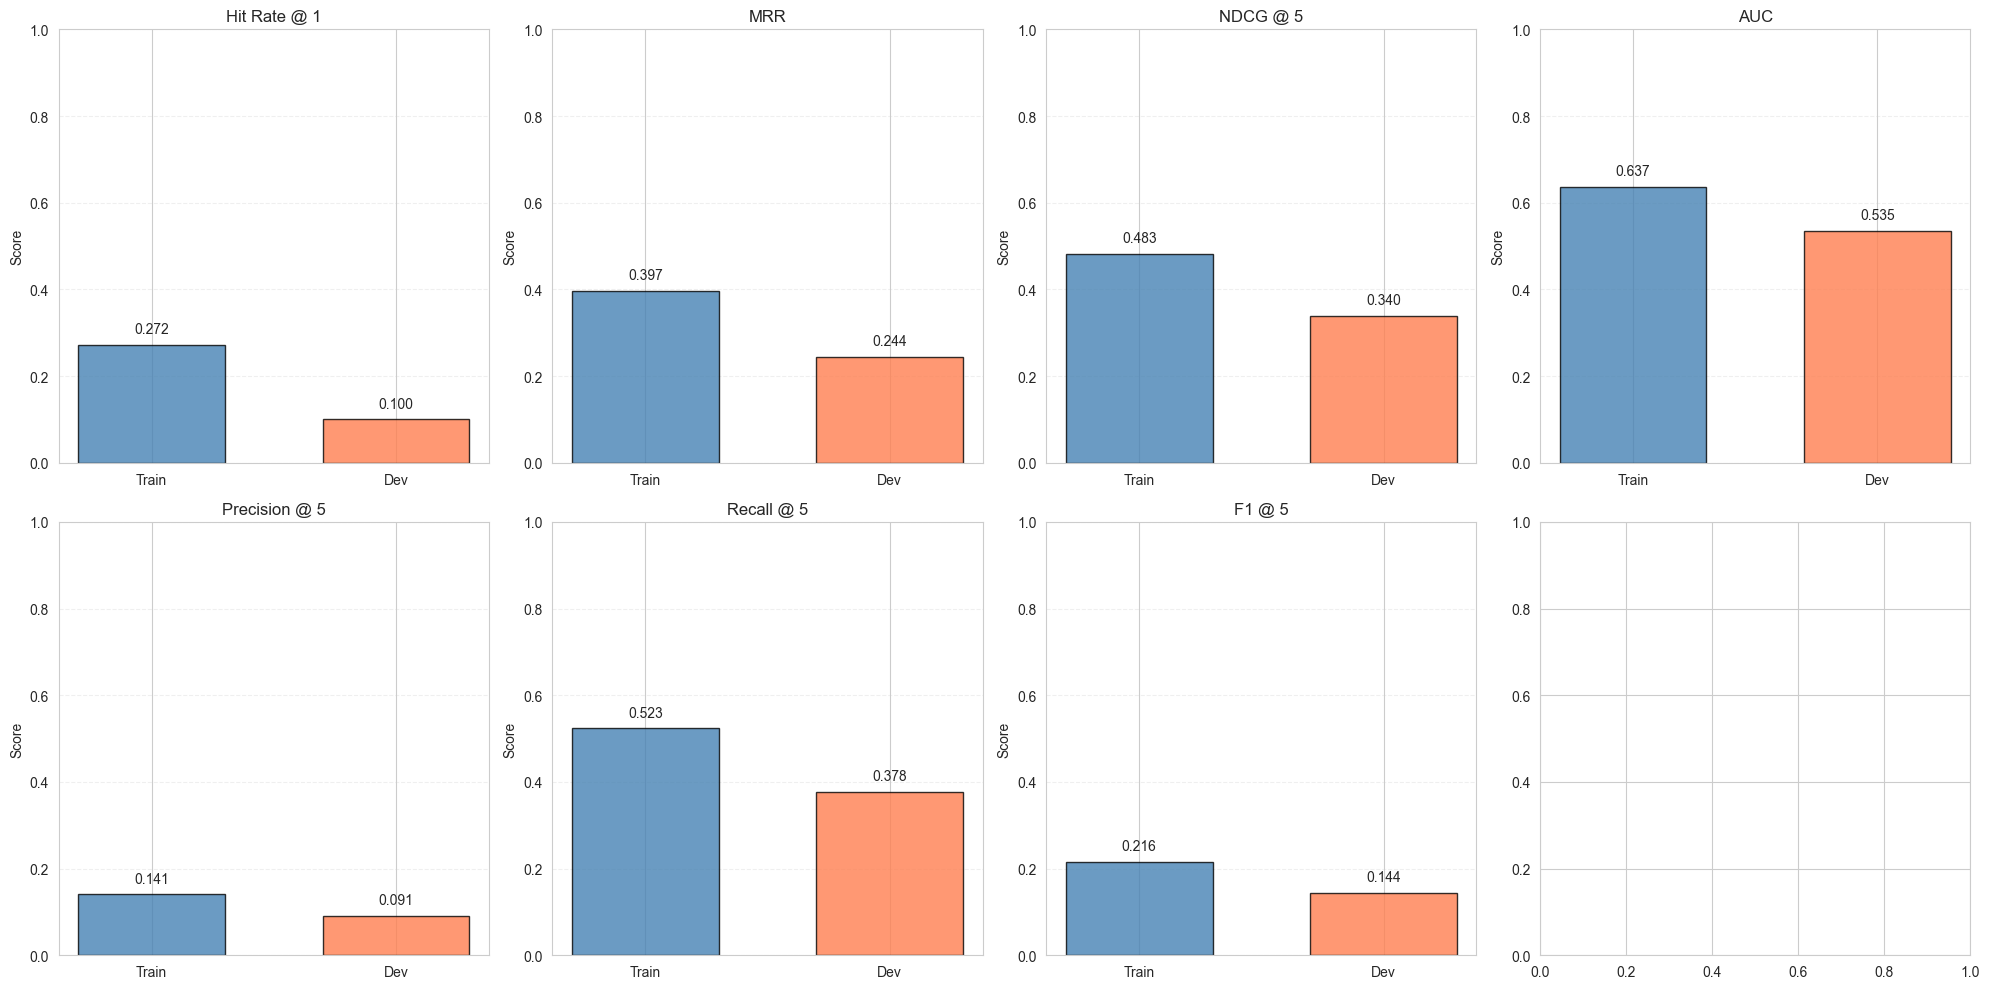

In [60]:
# Create comparison
comparison_df = pd.DataFrame({
    'Metric': ['Hit Rate @ 1', 'MRR', 'NDCG @ 5', 'AUC', 'Precision @ 5', 'Recall @ 5', 'F1 @ 5', 'Coverage'],
    'Train': [train_metrics['Hit Rate @ 1'], train_metrics['MRR'], train_metrics['NDCG @ 5'], 
              train_metrics['AUC'], train_metrics['Precision @ 5'], train_metrics['Recall @ 5'], train_metrics['F1 @ 5'],
              train_metrics['Coverage']],
    'Dev': [dev_metrics['Hit Rate @ 1'], dev_metrics['MRR'], dev_metrics['NDCG @ 5'], 
            dev_metrics['AUC'], dev_metrics['Precision @ 5'], dev_metrics['Recall @ 5'], dev_metrics['F1 @ 5'],
            dev_metrics['Coverage']]
})
comparison_df['Difference'] = comparison_df['Train'] - comparison_df['Dev']
comparison_df['Relative Diff %'] = ((comparison_df['Train'] - comparison_df['Dev']) / comparison_df['Train'] * 100).round(2)

print("Train vs Dev Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
metrics_to_plot = ['Hit Rate @ 1', 'MRR', 'NDCG @ 5', 'AUC', 'Precision @ 5', 'Recall @ 5', 'F1 @ 5']

for i, metric in enumerate(metrics_to_plot):
    row = i // 4
    col = i % 4
    train_val = comparison_df[comparison_df['Metric'] == metric]['Train'].values[0]
    dev_val = comparison_df[comparison_df['Metric'] == metric]['Dev'].values[0]
    
    axes[row, col].bar(['Train', 'Dev'], [train_val, dev_val], width=0.6, 
                color=['steelblue', 'coral'], alpha=0.8, edgecolor='black')
    axes[row, col].set_ylabel('Score')
    axes[row, col].set_title(metric)
    axes[row, col].set_ylim([0, 1.0])
    axes[row, col].grid(axis='y', alpha=0.3, linestyle='--')
    axes[row, col].text(0, train_val + 0.02, f'{train_val:.3f}', ha='center', va='bottom')
    axes[row, col].text(1, dev_val + 0.02, f'{dev_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
